# A/B Testing - Frequentist Approach.

In [1]:
reset -fs

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import beta as beta_dist
from scipy import stats
%matplotlib inline

In [3]:
baseline_df = pd.read_csv('data/baseline.csv', header=None).T

In [4]:
baseline_df

,0,1,2,3,4,5,6
0,Unique cookies to view page per day:,"Unique cookies to click ""Start free trial"" per...",Enrollments per day:,"Click-through-probability on ""Start free trial"":","Probability of enrolling, given click:","Probability of payment, given enroll:","Probability of payment, given click"
1,40000,3200,660,0.08,0.20625,0.53,0.109313


In [5]:
new_header = baseline_df.iloc[0] #grab the first row for the header
baseline_df = baseline_df[1:] #take the data less the header row
baseline_df.rename(columns = new_header) #set the header row as the df header

,Unique cookies to view page per day:,"Unique cookies to click ""Start free trial"" per day:",Enrollments per day:,"Click-through-probability on ""Start free trial"":","Probability of enrolling, given click:","Probability of payment, given enroll:","Probability of payment, given click"
1,40000,3200,660,0.08,0.20625,0.53,0.109313


In [6]:
control_df = pd.read_csv('data/control.csv')

In [7]:
control_df.rename(columns={'Date': 'date', 'Pageviews': 'unique_cookies_pageviews', 'Clicks': 'unique_cookies_clicks', 'Enrollments': 'users_enrolled', 'Payments': 'user_enrolled_payments'}, inplace=True)

In [8]:
control_df

,date,unique_cookies_pageviews,unique_cookies_clicks,users_enrolled,user_enrolled_payments
0,"Sat, Oct 11",7723,687,134.0,70.0
1,"Sun, Oct 12",9102,779,147.0,70.0
2,"Mon, Oct 13",10511,909,167.0,95.0
3,"Tue, Oct 14",9871,836,156.0,105.0
4,"Wed, Oct 15",10014,837,163.0,64.0
5,"Thu, Oct 16",9670,823,138.0,82.0
6,"Fri, Oct 17",9008,748,146.0,76.0
7,"Sat, Oct 18",7434,632,110.0,70.0
8,"Sun, Oct 19",8459,691,131.0,60.0
9,"Mon, Oct 20",10667,861,165.0,97.0


In [9]:
control_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 5 columns):
date                        37 non-null object
unique_cookies_pageviews    37 non-null int64
unique_cookies_clicks       37 non-null int64
users_enrolled              23 non-null float64
user_enrolled_payments      23 non-null float64
dtypes: float64(2), int64(2), object(1)
memory usage: 1.5+ KB


In [10]:
control_df.describe()

//anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,unique_cookies_pageviews,unique_cookies_clicks,users_enrolled,user_enrolled_payments
count,37.000000,37.000000,23.000000,23.000000
mean,9339.000000,766.972973,164.565217,88.391304
std,740.239563,68.286767,29.977000,20.650202
min,7434.000000,632.000000,110.000000,56.000000
25%,8896.000000,708.000000,NaN,NaN
50%,9420.000000,759.000000,NaN,NaN
75%,9871.000000,825.000000,NaN,NaN
max,10667.000000,909.000000,233.000000,128.000000


In [11]:
experiment_df = pd.read_csv('data/experiment.csv')

In [12]:
experiment_df.rename(columns={'Date': 'date', 'Pageviews': 'unique_cookies_pageviews', 'Clicks': 'unique_cookies_clicks', 'Enrollments': 'users_enrolled', 'Payments': 'user_enrolled_payments'}, inplace=True)

In [13]:
experiment_df

,date,unique_cookies_pageviews,unique_cookies_clicks,users_enrolled,user_enrolled_payments
0,"Sat, Oct 11",7716,686,105.0,34.0
1,"Sun, Oct 12",9288,785,116.0,91.0
2,"Mon, Oct 13",10480,884,145.0,79.0
3,"Tue, Oct 14",9867,827,138.0,92.0
4,"Wed, Oct 15",9793,832,140.0,94.0
5,"Thu, Oct 16",9500,788,129.0,61.0
6,"Fri, Oct 17",9088,780,127.0,44.0
7,"Sat, Oct 18",7664,652,94.0,62.0
8,"Sun, Oct 19",8434,697,120.0,77.0
9,"Mon, Oct 20",10496,860,153.0,98.0


In [14]:
experiment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 5 columns):
date                        37 non-null object
unique_cookies_pageviews    37 non-null int64
unique_cookies_clicks       37 non-null int64
users_enrolled              23 non-null float64
user_enrolled_payments      23 non-null float64
dtypes: float64(2), int64(2), object(1)
memory usage: 1.5+ KB


In [15]:
experiment_df.describe()

//anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,unique_cookies_pageviews,unique_cookies_clicks,users_enrolled,user_enrolled_payments
count,37.000000,37.000000,23.000000,23.000000
mean,9315.135135,765.540541,148.826087,84.565217
std,708.070781,64.578374,33.234227,23.060841
min,7664.000000,642.000000,94.000000,34.000000
25%,8881.000000,722.000000,NaN,NaN
50%,9359.000000,770.000000,NaN,NaN
75%,9737.000000,827.000000,NaN,NaN
max,10551.000000,884.000000,213.000000,123.000000


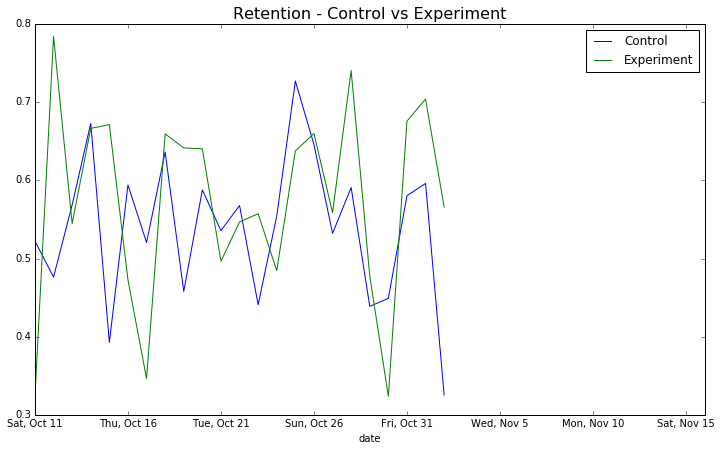

In [16]:
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111)
plt.title("Retention - Control vs Experiment", fontsize="16" )
pd.DataFrame({'Control': control_df['user_enrolled_payments']/control_df['users_enrolled']}).plot(kind='line', ax=ax, legend=True, x=control_df['date'])
pd.DataFrame({'Experiment': experiment_df['user_enrolled_payments']/experiment_df['users_enrolled']}).plot(kind='line', ax=ax, legend=True, x=control_df['date']);

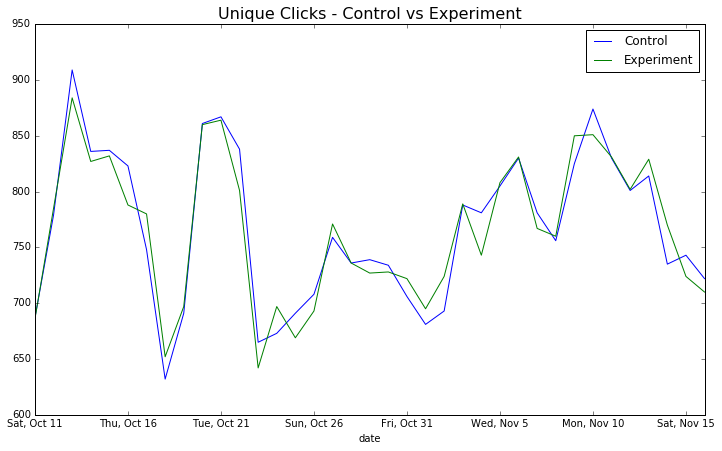

In [17]:
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111)
plt.title("Unique Clicks - Control vs Experiment", fontsize="16" )
pd.DataFrame({'Control': control_df['unique_cookies_clicks']}).plot(kind='line', ax=ax, legend=True, x=control_df['date'])
pd.DataFrame({'Experiment': experiment_df['unique_cookies_clicks']}).plot(kind='line', ax=ax, legend=True, x=control_df['date']);

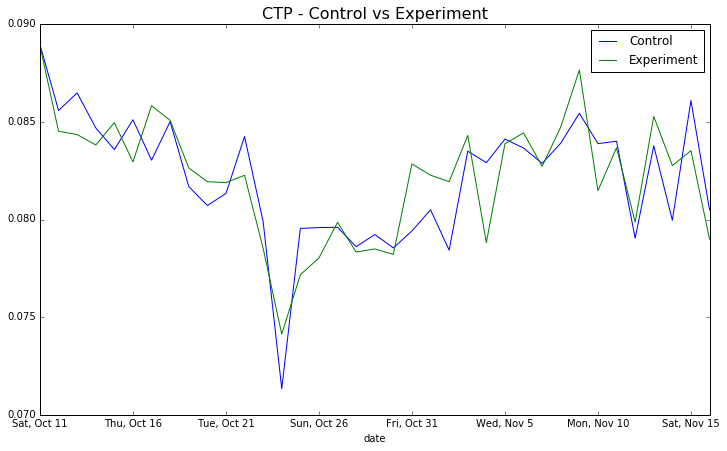

In [18]:
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111)
plt.title("CTP - Control vs Experiment", fontsize="16" )
pd.DataFrame({'Control': control_df['unique_cookies_clicks']/control_df['unique_cookies_pageviews']}).plot(kind='line', ax=ax, legend=True, x=control_df['date'])
pd.DataFrame({'Experiment': experiment_df['unique_cookies_clicks']/experiment_df['unique_cookies_pageviews']}).plot(kind='line', ax=ax, legend=True, x=control_df['date']);

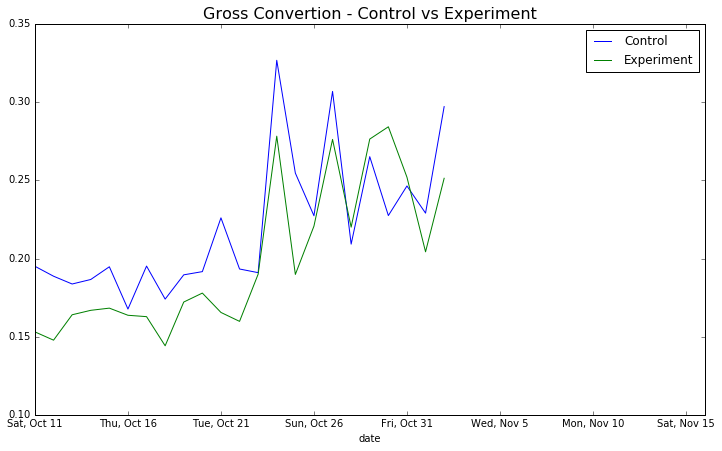

In [19]:
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111)
plt.title("Gross Convertion - Control vs Experiment", fontsize="16" )
pd.DataFrame({'Control': control_df['users_enrolled']/control_df['unique_cookies_clicks']}).plot(kind='line', ax=ax, legend=True, x=control_df['date'])
pd.DataFrame({'Experiment': experiment_df['users_enrolled']/experiment_df['unique_cookies_clicks']}).plot(kind='line', ax=ax, legend=True, x=control_df['date']);

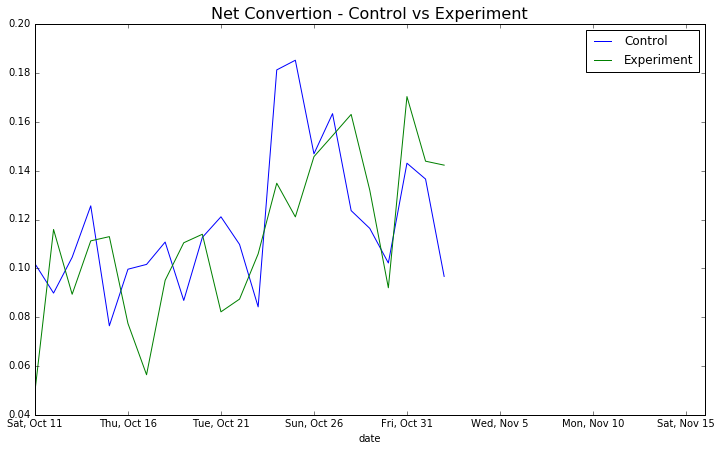

In [20]:
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111)
plt.title("Net Convertion - Control vs Experiment", fontsize="16" )
pd.DataFrame({'Control': control_df['user_enrolled_payments']/control_df['unique_cookies_clicks']}).plot(kind='line', ax=ax, legend=True, x=control_df['date'])
pd.DataFrame({'Experiment': experiment_df['user_enrolled_payments']/experiment_df['unique_cookies_clicks']}).plot(kind='line', ax=ax, legend=True, x=control_df['date']);

In [21]:
def p_hat_N_baseline(dataframe_column_1, dataframe_column_2):
    """
    INPUT: columns from the baseline dataframe.
    OUTPUT: metrics derived from above columns.
    """
    z = 1.96
    p_hat_baseline = dataframe_column_1[1]
    N = dataframe_column_2[1]
    margin_of_error = z * np.sqrt(p_hat_baseline * (1 - p_hat_baseline)/N)
    print("P hat baseline: {:.2%}".format(p_hat_baseline))
    print("\nN: {:0,.2f}".format(N))
    print("\nMargin of Error: {:.2%}".format(margin_of_error))
    
    return p_hat_baseline, N, margin_of_error

In [22]:
def control_experiment(control_column_1, control_column_2, experiment_column_1, experiment_column_2):
    """
    INPUT: two columns for each of two dataframes.
    OUTPUT: different metrics calculated from the above columns.
    """
    z = 1.96
    x_control = control_column_1.sum()
    x_experiment = experiment_column_1.sum()
    N_control = control_column_2.sum()
    N_experiment = experiment_column_2.sum()
    p_hat_pool = (x_control + x_experiment)/(N_control + N_experiment)
    standard_error_pool = np.sqrt(p_hat_pool * (1 - p_hat_pool) * ((1/N_control) + (1/N_experiment)))
    margin_of_error_pool = standard_error_pool * z
    confidence_interval = (0.5 - margin_of_error_pool, 0.5 + margin_of_error_pool)
    p_hat_control = control_column_1.mean()
    p_hat_experiment = experiment_column_1.mean()
    d_hat = p_hat_experiment - p_hat_control
    print("P hat pool: {:.2%}".format(p_hat_pool))
    print("Standard Error Pool: {:.2%}".format(standard_error_pool))
    print("D hat: {:.2f}".format(d_hat))
    
    return x_control, x_experiment, N_control, N_experiment, p_hat_pool, standard_error_pool, margin_of_error_pool, confidence_interval, p_hat_control, p_hat_experiment, d_hat

In [23]:
def reject_null_hypothesis(d_hat, standard_error_pool, z=1.96):
    """
    INPUT: d hat and standard deviation.
    OUTPUT: we evaluate whether d hat is greater or not z times the standard deviation.
    """
    if d_hat < 0:
        evaluation = -z * standard_error_pool
        if d_hat < evaluation:
            print("Reject the null hypothesis.")
        else:
            print("Fail to reject the null hypothesis.")
    else:
        evaluation = z * standard_error_pool
        if d_hat > evaluation:
            print("Reject the null hypothesis.")
        else:
            print("Fail to reject the null hypothesis.")

In [24]:
def sanity_check(control_column_1, experiment_column_1):
    """
    INPUT: columns of two different dataframes.
    OUTPUT: an integer calculated from above input.
    """
    N_control = control_column_1.sum()
    N_experiment = experiment_column_1.sum()
    
    return N_control/(N_control + N_experiment)
    

$H_0 = \hat{p}_{control} - \hat{p}_{experiment} = 0$

$H_A = \hat{p}_{control} - \hat{p}_{experiment} \neq 0$

### Experiment with metric: `CTP`.

In [25]:
p_hat_baseline, N, margin_of_error = p_hat_N_baseline(baseline_df.ix[:,3], baseline_df.ix[:,0])

P hat baseline: 8.00%

N: 40,000.00

Margin of Error: 0.27%


In [26]:
margin_of_error_upper = p_hat_baseline + margin_of_error

In [27]:
margin_of_error_lower = p_hat_baseline - margin_of_error

In [28]:
margin_of_error_lower, margin_of_error_upper

(0.077341326646614902, 0.082658673353385101)

In [29]:
x_control, x_experiment, N_control, N_experiment, p_hat_pool, standard_error_pool, margin_of_error_pool, confidence_interval, p_hat_control, p_hat_experiment, d_hat = control_experiment(control_df['unique_cookies_clicks'],
                                                                                  control_df['unique_cookies_pageviews'],
                                                                   experiment_df['unique_cookies_clicks'],
                                                                   experiment_df['unique_cookies_pageviews'])

P hat pool: 8.22%
Standard Error Pool: 0.07%
D hat: -1.43


In [30]:
x_control, x_experiment, N_control, N_experiment, p_hat_pool, standard_error_pool, margin_of_error_pool, confidence_interval, p_hat_control, p_hat_experiment, d_hat

(28378,
 28325,
 345543,
 344660,
 0.08215409089789526,
 0.00066106081563872224,
 0.0012956791986518956,
 (0.49870432080134808, 0.50129567919865192),
 766.972972972973,
 765.5405405405405,
 -1.4324324324325062)

In [31]:
reject_null_hypothesis(d_hat, standard_error_pool)

Reject the null hypothesis.


#### We reject $H_0$

In [32]:
print("Standard Deviation for CTP: {:.4f}".format((experiment_df['unique_cookies_clicks']/ experiment_df['unique_cookies_pageviews']).std()))

Standard Deviation for CTP: 0.0031


In [33]:
print("Sanity Check Observed Value: {:.4f}".format(sanity_check(control_df['unique_cookies_pageviews'], experiment_df['unique_cookies_pageviews'])))

Sanity Check Observed Value: 0.5006


### Experiment with metric: `Gross Conversion`.

In [34]:
p_hat_baseline, N, margin_of_error = p_hat_N_baseline(baseline_df.ix[:,6], baseline_df.ix[:,0])

P hat baseline: 10.93%

N: 40,000.00

Margin of Error: 0.31%


In [35]:
x_control, x_experiment, N_control, N_experiment, p_hat_pool, standard_error_pool, margin_of_error_pool, confidence_interval, p_hat_control, p_hat_experiment, d_hat = control_experiment(control_df['users_enrolled'],
                                                                                  control_df['unique_cookies_clicks'],
                                                                   experiment_df['users_enrolled'],
                                                                   experiment_df['unique_cookies_clicks'])

P hat pool: 12.71%
Standard Error Pool: 0.28%
D hat: -15.74


In [36]:
x_control, x_experiment, N_control, N_experiment, p_hat_pool, standard_error_pool, margin_of_error_pool, confidence_interval, p_hat_control, p_hat_experiment, d_hat

(3785.0,
 3423.0,
 28378,
 28325,
 0.127118494612278,
 0.0027977517973336854,
 0.005483593522774023,
 (0.494516406477226, 0.50548359352277406),
 164.56521739130434,
 148.82608695652175,
 -15.739130434782595)

In [37]:
reject_null_hypothesis(d_hat, standard_error_pool)

Reject the null hypothesis.


#### We reject $H_0$

In [38]:
print("Standard Deviation for Control Gross Conversion: {:.4f}".format((control_df['users_enrolled']/ control_df['unique_cookies_clicks']).std()))

Standard Deviation for Control Gross Conversion: 0.0440


In [39]:
print("Standard Deviation for Experiment Gross Conversion: {:.4f}".format((experiment_df['users_enrolled']/ experiment_df['unique_cookies_clicks']).std()))

Standard Deviation for Experiment Gross Conversion: 0.0475


In [40]:
print("Sanity Check Observed Value: {:.4f}".format(sanity_check(control_df['unique_cookies_clicks'], experiment_df['unique_cookies_clicks'])))

Sanity Check Observed Value: 0.5005


### Experiment with metric: `Net Conversion`.

In [41]:
p_hat_baseline, N, margin_of_error = p_hat_N_baseline(baseline_df.ix[:,4], baseline_df.ix[:,0])

P hat baseline: 20.62%

N: 40,000.00

Margin of Error: 0.40%


In [42]:
x_control, x_experiment, N_control, N_experiment, p_hat_pool, standard_error_pool, margin_of_error_pool, confidence_interval, p_hat_control, p_hat_experiment, d_hat = control_experiment(control_df['user_enrolled_payments'],
                                                                                  control_df['unique_cookies_clicks'],
                                                                   experiment_df['user_enrolled_payments'],
                                                                   experiment_df['unique_cookies_clicks'])

P hat pool: 7.02%
Standard Error Pool: 0.21%
D hat: -3.83


In [43]:
reject_null_hypothesis(d_hat, standard_error_pool)

Reject the null hypothesis.


#### We reject $H_0$

In [44]:
print("Standard Deviation for Control Net Conversion: {:.4f}".format((control_df['user_enrolled_payments']/ control_df['unique_cookies_clicks']).std()))

Standard Deviation for Control Net Conversion: 0.0294


In [45]:
print("Standard Deviation for Experiment Net Conversion: {:.4f}".format((experiment_df['user_enrolled_payments']/ experiment_df['unique_cookies_clicks']).std()))

Standard Deviation for Experiment Net Conversion: 0.0322


In [46]:
print("Sanity Check Observed Value: {:.4f}".format(sanity_check(control_df['unique_cookies_clicks'], experiment_df['unique_cookies_clicks'])))

Sanity Check Observed Value: 0.5005


## Sample size.

### For CTP.

In [47]:
baseline = baseline_df.ix[:,3]
dmin = 0.01

In [48]:
baseline[1]

0.08

http://www.evanmiller.org/ab-testing/sample-size.html#!10.9313;80;5;0.75;0

<img src="images/sample-size.jpg" />

### For Gross Conversion.

In [49]:
baseline = baseline_df.ix[:,4]
dmin = 0.01

In [50]:
baseline[1]

0.20625

<img src="images/sample-size-2.jpg" />

### For Net Conversion.

In [51]:
baseline = baseline_df.ix[:,6]
dmin = 0.0075

In [52]:
baseline[1]

0.1093125

<img src="images/sample-size-3.jpg" />

### For Retention.

In [53]:
baseline = baseline_df.ix[:,5]
dmin = 0.01

In [54]:
baseline[1]

0.53

<img src="images/sample-size-4.jpg" />